In [1]:
%matplotlib inline

In [2]:
from typing import Dict

FileAuthors = Dict[str, int]
RepoFileAuthors = Dict[str, FileAuthors]
AllRepoFileAuthors = Dict[str, RepoFileAuthors]

# test_dict: AllRepoFileAuthors = {
#     'repo name': {
#         '/file/path': {
#             'author name': 12345  # line count
#         }
#     }
# }

In [24]:
import subprocess

def blame(file, repo_root):
    return subprocess.run(["git", "blame", "--line-porcelain", file],
       capture_output=True,
       cwd=repo_root
    ).stdout.decode("utf8")

def git_ls_files(repo_root, dir=None):
    args = ["git", "ls-files"]
    if dir is not None:
        args.append(dir) 
        
    p = subprocess.run(args,
       capture_output=True,
       cwd=repo_root
    )
    
    if p.returncode != 0:
        return p.stderr.decode("utf8")
    return p.stdout.decode("utf8").split("\n")

def add_lines(counts: FileAuthors, author, start, end):
    if author not in counts:
        counts[author] = 0
        
    diff = end - start
    counts[author] += diff

def count_repo(executor, repo_root, filter_func):
    counts = {}
    files = git_ls_files(repo_root=repo_root)
    for f in files:
        if filter_func(f):
            continue
        counts[f]: FileAuthors = executor.submit(count_file, f, repo_root)
    return counts

def count_file(f, repo_root):
    counts: FileAuthors = {}
    last_author_header_ln = 1
    last_header_ln = 1
    last_author_name = None

    blame_lines = blame(f, repo_root).split("\n")
    for j, line in enumerate(blame_lines):
        if line == "":
            continue
        header_match = header_re.match(line)
        if header_match is not None:
            header_new_ln = int(header_match.group(1))
            last_header_ln = int(header_new_ln)
            continue
        author_match = author_re.match(line)
        if author_match is not None:
            author = author_match.group(1)
            if last_author_name is None:
                last_author_name = author
                continue
            add_lines(counts, last_author_name, last_author_header_ln, last_header_ln)
            last_author_name = author
            last_author_header_ln = last_header_ln

    add_lines(counts, last_author_name, last_author_header_ln, last_header_ln + 1)
    return counts

In [39]:
import re, time, os.path as path
from concurrent.futures import ThreadPoolExecutor, as_completed

start = time.perf_counter()

max_workers = 15
root_dir = "/home/bwhite/Projects/bryanchriswhite"
repo_names = [
    "storj",
    "uplink",
    "uplink-c"
]
author_regex = re.compile("\S+\s+\(([\w ]+)\s*?\d{4,}")

header_re = re.compile("\w{,40} \d+ (\d+)(:? (\d+))?")
author_re = re.compile("author (.+)$")
excluded_exts = set()
repo_counts: AllRepoFileAuthors = {}

def filter_files(filename):
    ext = path.splitext(filename)[1]
    ext_whitelist = (
        ".go", ".c", ".h", ".sh", ".md", ".xml", ".wixproj", ".wsx"
    )
    exclude = filename == "" or ext not in ext_whitelist
    
    if exclude:
        excluded_exts.add(ext)
    
    return exclude

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    results = {}
    for name in repo_names:
        repo_root = path.join(root_dir, name)
        results[name] = count_repo(executor, repo_root, filter_files)
        # results[name] = [executor.submit(count, f, repo_root) for f in files]

    # for name, counts in [(n, f.result()) for n, f in results.items()]:

    for name, future in results.items():
        # print(future)
        # result = future.result()
        # print(result)
        # count: RepoFileAuthors = result
        # repo_counts[name] = count
        repo_counts[name] = {k: v.result() for k, v in future.items()}

end = time.perf_counter()
print(str.format("done: {}s!", round(end - start, 2)))
print(str.format("excluded file extensions: {}", excluded_exts))

done: 9.47s!
excluded file extensions: {'', '.cert', '.sql', '.vue', '.tmpl', '.cs', '.bat', '.key', '.service', '.yaml', '.public', '.java', '.rtf', '.gradle', '.gif', '.pro', '.pem', '.css', '.svg', '.png', '.json', '.scss', '.pom', '.ico', '.csv', '.properties', '.ttf', '.config', '.jpg', '.snap', '.py', '.mod', '.sum', '.wxs', '.sln', '.zip', '.html', '.ts', '.bmp', '.js', '.pdf', '.csproj', '.dbx', '.jar', '.lock'}


In [41]:
totals: Dict[str, Dict[str, int]] = {}
total_lines = {}
to_percent = lambda tup, total: round((tup[1] / total) * 100, 2)

for repo, files_author_line_counts in repo_counts.items():
    # print("new repo " + repo)
    repo_totals: Dict[str, int] = {}
    total_lines[repo] = 0
            
    for author_line_counts in files_author_line_counts.values():
        for author, counts in author_line_counts.items():
            total_lines[repo] += counts
            
            if author not in repo_totals:
                repo_totals[author] = 0
            repo_totals[author] += counts
    totals[repo] = repo_totals
        
def print_totals(t):
    for i, author, total, pct in t:
        print(str.format("#{}: {} ({}% | {})", i, author, pct, total))
        
# print(totals)
totals_to_graph = {}
for repo, totals in totals.items():
    total_list = [(*tup, to_percent(tup, total_lines[repo])) for tup in totals.items()]
    total_list.sort(key=lambda x: x[1], reverse=True)
    total_list = [[i+1, *tup] for i, tup in enumerate(total_list)]
    
    totals_to_graph[repo] = total_list

    print(repo)
    print_totals(total_list[:10])
    print()


storj
#1: Egon Elbre (15.01% | 24772)
#2: paul cannon (9.21% | 15203)
#3: Michal Niewrzal (6.99% | 11536)
#4: Jeff Wendling (6.69% | 11042)
#5: Yaroslav Vorobiov (6.65% | 10977)
#6: Isaac Hess (4.83% | 7975)
#7: Bryan White (4.62% | 7626)
#8: Yingrong Zhao (3.45% | 5700)
#9: Maximillian von Briesen (3.04% | 5020)
#10: Natalie Villasana (2.92% | 4820)

uplink
#1: Kaloyan Raev (31.97% | 3608)
#2: Egon Elbre (25.52% | 2881)
#3: Michal Niewrzal (22.86% | 2580)
#4: JT Olio (4.61% | 520)
#5: Ivan Fraixedes (2.49% | 281)
#6: Maximillian von Briesen (2.04% | 230)
#7: Jeff Wendling (1.9% | 214)
#8: Natalie Villasana (1.51% | 170)
#9: ccase (1.28% | 145)
#10: Jess G (0.89% | 101)

uplink-c
#1: Egon Elbre (85.13% | 2593)
#2: Michal Niewrzal (12.34% | 376)
#3: Kaloyan Raev (2.53% | 77)



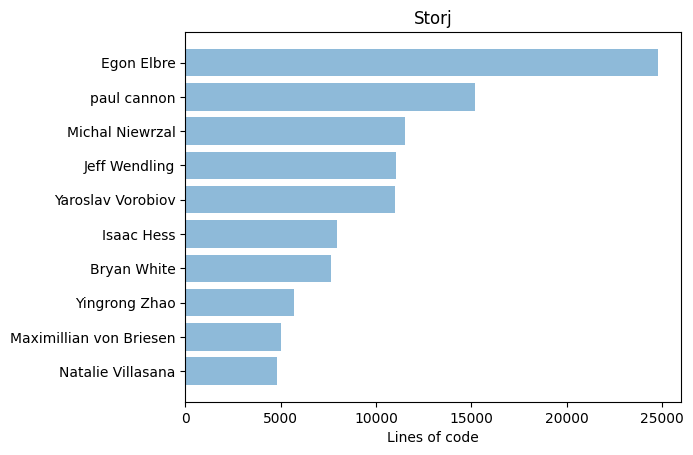

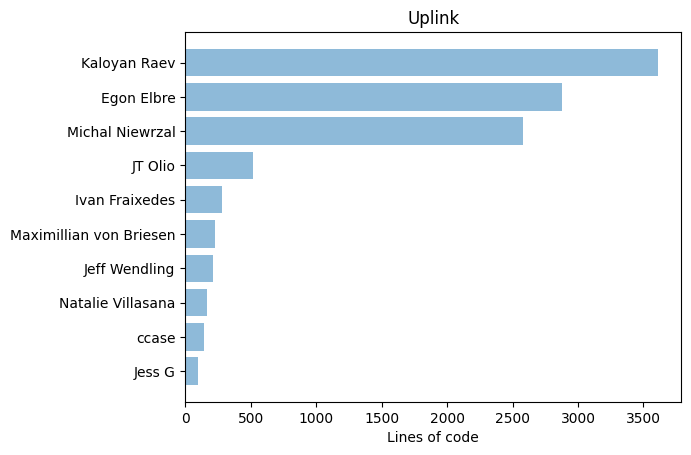

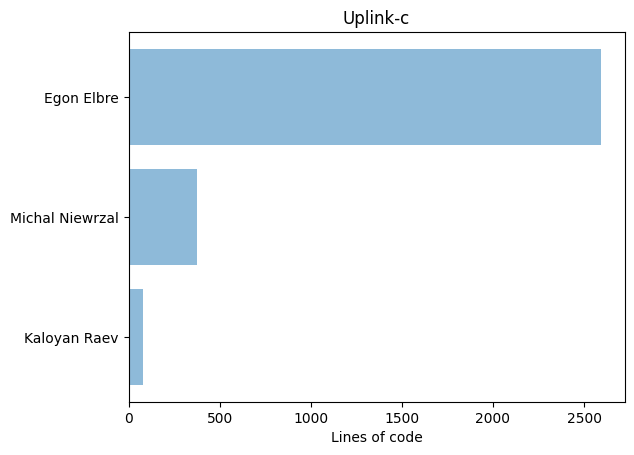

In [30]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

for repo, total_list in totals_to_graph.items():
    total_list = total_list[:10]
    total_list.reverse()

    y_pos = np.arange(len(total_list))

    performance = [t[2] for t in total_list]
    objects = [t[1] for t in total_list]

    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Lines of code')
    plt.title(str.format("{}", repo.capitalize()))

    plt.show()
                    

In [ ]:
# data to plot
n_groups = 4
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.barh(index, means_frank, bar_width,
alpha=opacity,
color='b',
label='Frank')

rects2 = plt.barh(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='g',
label='Guido')

plt.ylabel('Person')
plt.xlabel('Scores')
plt.title('Scores by person')
# plt.yticks(index/2 + bar_width, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# data to plot
n_groups = 4
means_frank = (90, 55, 40, 65)
means_guido = (85, 62, 54, 20)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
alpha=opacity,
color='#0bf',
label='Frank')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
alpha=opacity,
color='#3fd',
label='Guido')

plt.xlabel('Person')
plt.ylabel('Scores')
plt.title('Scores by person')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
for f, author_line_counts in files_author_line_counts.items():
    print(f)
    for author, line_count in author_line_counts.items():
        print(str.format("    {}: {}", author, line_count))
                    

In [ ]:
from github import Github

apikey = open("github.apikey")

g = Github()
org = g.get_organization("storj")
repos = org.get_repos()
page = repos.get_page(0)

storj_repos = page

In [ ]:
[(r.name, r.created_at) for r in storj_repos]